# Performing z-m-M cosmology fitting

In [1]:
import cosmographi as cg
import caskade as ck
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from time import time

print(jax.config.jax_enable_x64)

True


## Making a SN sample

In [2]:
# Define the simulator
cosmology = cg.Cosmology()
rateIa = cg.sn.SNRateConst(cosmology, 1e-4, z_min=0.0, z_max=2.0, name="rateIa")
rateIbc = cg.sn.SNRateConst(cosmology, 5e-5, z_min=0.0, z_max=2.0, name="rateIbc")
ratecombined = cg.sn.CombinedSNRate((rateIa, rateIbc), z_min=0.0, z_max=2.0, cosmology=cosmology)
absmagIa = cg.sn.SNAbsMagGaussian(-19.3, 0.2, name="absmagIa")
absmagIbc = cg.sn.SNAbsMagGaussian(-17.0, 1.5, name="absmagIbc")
detect_Ia = cg.sn.mSigmoidDetect(threshold=-4, scale=0.1, name="detectIa")
detect_Ibc = cg.sn.mSigmoidDetect(threshold=-4.1, scale=0.13, name="detectIbc")

# Define sampling parameters
n_samples = 500
var_m_Ia = lambda z: 0.2**2 * z
var_z_Ia = lambda z: 0.1**2 * z
cov_Ia = lambda key, var_z, var_m: jax.random.uniform(
    key, var_m.shape, minval=0, maxval=jnp.sqrt(var_m * var_z) * 0.7
)
var_m_Ibc = lambda z: 1.5**2 * z
var_z_Ibc = lambda z: 0.2**2 * z
cov_Ibc = lambda key, var_z, var_m: jax.random.uniform(
    key, var_m.shape, minval=0, maxval=jnp.sqrt(var_m * var_z) * 0.7
)

# Sample SN
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
# sample SN redshifts
z = ratecombined.sample(subkey, n_samples)
# sample SN types
t = []
for i in range(n_samples):
    key, subkey = jax.random.split(key)
    t.append(ratecombined.sample_type(subkey, z[i]))
t = jnp.array(t)
# Compute true absolute magnitudes
key, subkey1 = jax.random.split(key)
key, subkey2 = jax.random.split(key)
M = jnp.where(t == 0, absmagIa.sample(subkey1, z.shape), absmagIbc.sample(subkey2, z.shape))
# compute true distance modulus
DL = jax.vmap(cosmology.luminosity_distance)(z)
mu = 5 * jnp.log10(DL) - 5
# determine true apparent magnitudes
m = M + mu
# determine observational uncertainties
var_z = jnp.stack((var_z_Ia(z), var_z_Ibc(z)), axis=-1)  # (N, t)
var_m = jnp.stack((var_m_Ia(z), var_m_Ibc(z)), axis=-1)  # (N, t)
key, subkey1 = jax.random.split(key)
key, subkey2 = jax.random.split(key)
cov = jnp.stack(
    (cov_Ia(subkey1, var_m[:, 0], var_z[:, 0]), cov_Ibc(subkey2, var_m[:, 1], var_z[:, 1])),
    axis=-1,
)  # (N, t)
# sample observed apparent magnitudes
key, subkey = jax.random.split(key)
samp_varz = jnp.where(t == 0, var_z[:, 0], var_z[:, 1])
samp_varm = jnp.where(t == 0, var_m[:, 0], var_m[:, 1])
samp_cov = jnp.where(t == 0, cov[:, 0], cov[:, 1])
obs = jax.random.multivariate_normal(
    key,
    mean=jnp.stack((z, m), axis=-1),
    cov=jnp.stack(
        (jnp.stack((samp_varz, samp_cov), axis=-1), jnp.stack((samp_cov, samp_varm), axis=-1)),
        axis=-1,
    ),
)
z_obs = obs[:, 0]
m_obs = obs[:, 1]
obs_mean = obs  # (N, 2)
obs_cov = jnp.stack(
    (
        jnp.stack((var_z, cov), axis=-1),
        jnp.stack((cov, var_m), axis=-1),
    ),
    axis=-1,
)  # (N, t, 2, 2)
# sample detections
key, subkey1 = jax.random.split(key)
key, subkey2 = jax.random.split(key)
detected = jnp.where(
    t == 0, detect_Ia.sample(subkey1, z, m_obs), detect_Ibc.sample(subkey2, z, m_obs)
)

Number of detected SNe: 246 / 500


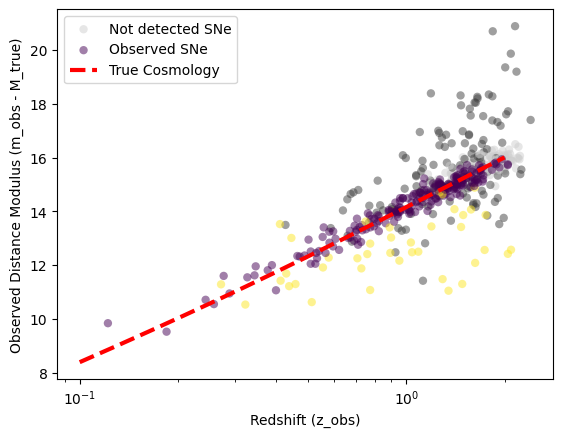

In [3]:
print(f"Number of detected SNe: {jnp.sum(detected)} / {n_samples}")
plt.scatter(
    z_obs[~detected],
    m_obs[~detected] - M[~detected],
    c=plt.get_cmap("Greys")(0.5 * t[~detected] + 0.3),
    alpha=0.5,
    label="Not detected SNe",
    linewidth=0,
)
plt.scatter(
    z_obs[detected],
    m_obs[detected] - M[detected],
    c=t[detected],
    cmap="viridis",
    alpha=0.5,
    label="Observed SNe",
    linewidth=0,
)
z_line = jnp.linspace(0.1, 2, 1000)
plt.plot(
    z_line,
    5 * jnp.log10(jax.vmap(cosmology.luminosity_distance)(z_line)) - 5,
    "r--",
    label="True Cosmology",
    linewidth=3,
)
plt.xlabel("Redshift (z_obs)")
plt.xscale("log")
plt.ylabel("Observed Distance Modulus (m_obs - M_true)")
plt.legend()
plt.show()

## Construct posterior density

In [4]:
cosmo_mean = jnp.array([0.307, -1])  # Omega_m, w
cosmo_cov = jnp.array([[0.1, 0], [0, 1.0]])
cosmology.Omega_m.to_dynamic()
cosmology.w0.to_dynamic()

detect_Ia_mean = jnp.array([-4, 0.1])  # threshold, scale
detect_Ia_cov = jnp.array([[1.0, 0], [0, 0.01]])
# detect_Ia.threshold.to_dynamic()
# detect_Ia.scale.to_dynamic()

detect_Ibc_mean = jnp.array([-4.1, 0.1])  # threshold, scale
detect_Ibc_cov = jnp.array([[1.0, 0], [0, 0.01]])
# detect_Ibc.threshold.to_dynamic()
# detect_Ibc.scale.to_dynamic()

In [5]:
class Likelihood(ck.Module):
    def __init__(
        self,
        cosmology: cg.Cosmology,
        ratecombined: cg.sn.CombinedSNRate,
        detect: list[cg.sn.mSigmoidDetect],
        absmag: list[cg.sn.SNAbsMagGaussian],
        name=None,
    ):
        super().__init__(name=name)
        self.cosmology = cosmology
        self.rate = ratecombined
        self.detect = detect
        self.absmag = absmag
        self.z = ck.Param("z", z[detected], description="Intrinsic redshift")
        self.M = ck.Param("M", M[detected], description="Intrinsic absolute magnitude")
        self.vsll = jax.vmap(
            lambda _xy, _i, _t: self.logP_m_theta(_i, _xy, t=_t), in_axes=(0, None, None)
        )

    @ck.forward
    def Z_zm_theta(self, i, t, z=None, M=None):
        mu = 5 * jnp.log10(self.cosmology.luminosity_distance(z[i])) - 5
        sigma = jnp.sqrt(var_m[i][t])
        m_obs_ = cg.utils.midpoints(M[i] + mu - 5 * sigma, M[i] + mu + 5 * sigma, 100)
        dA = m_obs_[1] - m_obs_[0]
        return jax.nn.logsumexp(self.vsll(m_obs_, i, t)) + jnp.log(dA)

    @ck.forward
    def logP_m_theta(self, i, m_obs_, z=None, M=None, t=None):
        mu = 5 * jnp.log10(self.cosmology.luminosity_distance(z[i])) - 5
        # P(z_obs, m_obs | z, M, t, Omega)
        po = -0.5 * (
            jnp.log(obs_cov[i][t][1, 1]) + ((m_obs_ - (M[i] + mu)) ** 2) / obs_cov[i][t][1, 1]
        )
        # P(d=1 | m_obs, z, t)
        pd = self.detect[t].log_prob(z[i], m_obs_)
        return po + pd

    @ck.forward
    def logP_zm_theta(self, i, z=None, M=None, t=None):
        mu = 5 * jnp.log10(self.cosmology.luminosity_distance(z[i])) - 5
        zm = jnp.array((z[i], M[i] + mu))
        # P(z_obs, m_obs | z, M, t, Omega)
        r = obs_mean[i] - zm
        po = -0.5 * (
            jnp.linalg.slogdet(obs_cov[i][t])[1] + jnp.dot(r, jnp.linalg.solve(obs_cov[i][t], r))
        )
        # P(d=1 | m_obs, z, t)
        pd = self.detect[t].log_prob(z[i], obs_mean[i][1])
        return po + pd

    @ck.forward
    def _log_likelihood(self, i, z=None, M=None):
        log_likelihood = []

        for t in range(len(self.detect)):
            # P(z| Omega, phi_t)
            ll = self.rate.logPz(z[i])
            # P(t|z, Omega, phi_t)
            ll = ll + self.rate.logPt_z(t, z[i])
            # P(M|t)
            ll = ll + self.absmag[t].logP_M(M[i])
            # P(m_obs | Omega, z, M, d=1, t)
            ll = ll + self.logP_zm_theta(i, t=t) - self.Z_zm_theta(i, t)
            log_likelihood.append(ll)
        return jax.nn.logsumexp(jnp.array(log_likelihood))

    @ck.forward
    def log_likelihood(self):
        return jax.vmap(self._log_likelihood)(jnp.arange(len(m_obs))).sum()


class Prior(ck.Module):
    def __init__(self, cosmology, detect, name=None):
        super().__init__(name=name)
        self.cosmology = cosmology
        self.detect = detect

    @ck.forward
    def log_prior(self):
        prior = 0
        # Cosmology prior
        params = jnp.array([self.cosmology.Omega_m.value, self.cosmology.w0.value])
        diff = params - jnp.array(cosmo_mean)
        exponent = -0.5 * jnp.dot(diff, jnp.linalg.solve(cosmo_cov, diff))
        norm = -0.5 * (len(params) * jnp.log(2 * jnp.pi) + jnp.linalg.slogdet(cosmo_cov)[1])
        prior = prior + norm + exponent
        prior = jnp.where(
            (params[0] <= 0) | (params[0] >= 1), -jnp.inf, prior
        )  # exclude unphysical Omega_m

        # Detect_Ia prior
        params = jnp.array([self.detect[0].threshold.value, self.detect[0].scale.value])
        diff = params - jnp.array(detect_Ia_mean)
        exponent = -0.5 * jnp.dot(diff, jnp.linalg.solve(detect_Ia_cov, diff))
        norm = -0.5 * (len(params) * jnp.log(2 * jnp.pi) + jnp.linalg.slogdet(detect_Ia_cov)[1])
        prior = prior + norm + exponent

        # Detect_Ibc prior
        params = jnp.array([self.detect[1].threshold.value, self.detect[1].scale.value])
        diff = params - jnp.array(detect_Ibc_mean)
        exponent = -0.5 * jnp.dot(diff, jnp.linalg.solve(detect_Ibc_cov, diff))
        norm = -0.5 * (len(params) * jnp.log(2 * jnp.pi) + jnp.linalg.slogdet(detect_Ibc_cov)[1])
        prior = prior + norm + exponent
        return prior


class Posterior(ck.Module):
    def __init__(self, likelihood, prior, name=None):
        super().__init__(name=name)
        self.likelihood = likelihood
        self.prior = prior

    @ck.forward
    def log_posterior(self):
        log_prior = self.prior.log_prior()
        log_likelihood = self.likelihood.log_likelihood()
        return log_prior + log_likelihood

In [6]:
posterior = Posterior(
    likelihood=Likelihood(
        cosmology,
        ratecombined,
        [detect_Ia, detect_Ibc],
        [absmagIa, absmagIbc],
        name=f"likelihood",
    ),
    prior=Prior(cosmology, [detect_Ia, detect_Ibc]),
)

start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)
start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)
start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)
start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)

-7993.200411351525
Time taken (s): 6.534794807434082
-7993.200411351525
Time taken (s): 0.38704657554626465
-7993.200411351525
Time taken (s): 0.5213878154754639
-7993.200411351525
Time taken (s): 0.4519994258880615


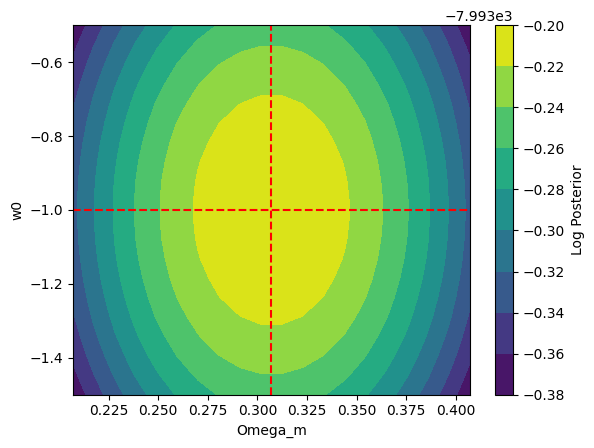

In [ ]:
Om = jnp.linspace(0.207, 0.407, 20)
Ow = jnp.linspace(-1.5, -0.5, 20)
x = jnp.stack(jnp.meshgrid(Om, Ow, indexing="ij"), axis=-1)
Lp = jax.vmap(posterior.log_posterior)(x.reshape(-1, 2)).reshape(20, 20)
plt.contourf(Om, Ow, Lp, levels=20, cmap="viridis")
plt.axvline(cosmo_mean[0], color="r", linestyle="--", label="True Omega_m")
plt.axhline(cosmo_mean[1], color="r", linestyle="--", label="True w0")
plt.colorbar(label="Log Posterior")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.show()

In [ ]:
posterior.likelihood.z.to_dynamic()
posterior.likelihood.M.to_dynamic()
x0 = posterior.build_params_array()
print(x0.shape)

chains = 16
key, subkey = jax.random.split(key)

# warmup
key, subkey = jax.random.split(key)
samples_burn = cg.utils.mala(
    jnp.repeat(x0[None, :], chains, axis=0),
    posterior.log_posterior,
    num_samples=500,
    epsilon=0.01,
    key=subkey,
    progress=True,
)
cov = jnp.diag(
    jnp.var(
        samples_burn[int(samples_burn.shape[0] / 2) :].reshape(-1, samples_burn.shape[-1]), axis=0
    )
)
print(cov.shape)

# production
key, subkey = jax.random.split(key)
samples_prod = cg.utils.mala(
    samples_burn[-1],
    posterior.log_posterior,
    mass_matrix=cov,
    num_samples=5000,
    epsilon=0.1,
    key=subkey,
    progress=True,
)

(494,)


MALA: 100%|██████████| 500/500 [01:40<00:00,  4.99it/s, acc_rate=0.61]


(494, 494)


MALA:  30%|███       | 1525/5000 [06:21<23:21,  2.48it/s, acc_rate=0.60]

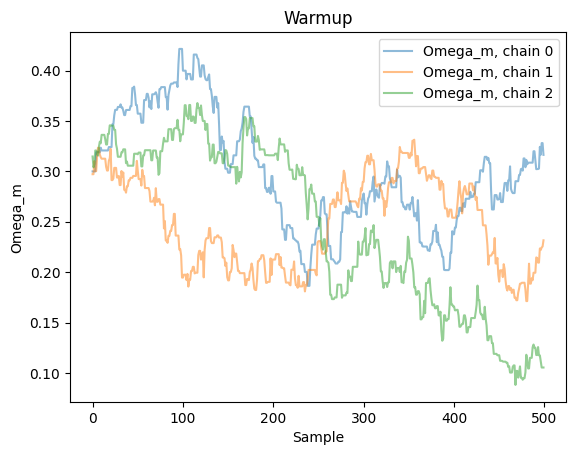

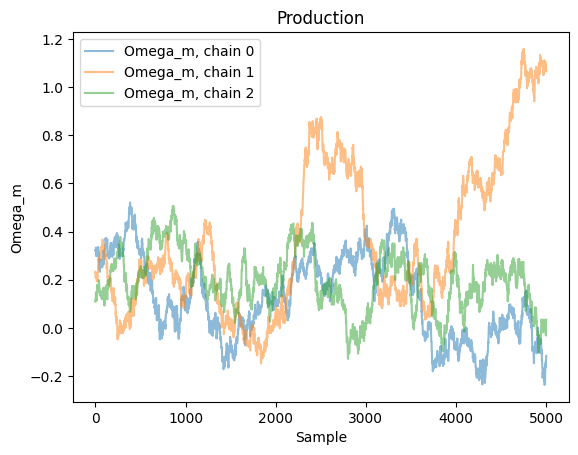

In [ ]:
plt.plot(range(samples_burn.shape[0]), samples_burn[:, 0, 0], alpha=0.5, label="Omega_m, chain 0")
plt.plot(range(samples_burn.shape[0]), samples_burn[:, 1, 0], alpha=0.5, label="Omega_m, chain 1")
plt.plot(range(samples_burn.shape[0]), samples_burn[:, 2, 0], alpha=0.5, label="Omega_m, chain 2")
plt.xlabel("Sample")
plt.ylabel("Omega_m")
plt.title("Warmup")
plt.legend()
plt.show()

plt.plot(range(samples_prod.shape[0]), samples_prod[:, 0, 0], alpha=0.5, label="Omega_m, chain 0")
plt.plot(range(samples_prod.shape[0]), samples_prod[:, 1, 0], alpha=0.5, label="Omega_m, chain 1")
plt.plot(range(samples_prod.shape[0]), samples_prod[:, 2, 0], alpha=0.5, label="Omega_m, chain 2")
plt.xlabel("Sample")
plt.ylabel("Omega_m")
plt.title("Production")
plt.legend()
plt.show()

In [ ]:
print(posterior.dynamic_params)
print(posterior)

(Omega_m, w0, z, M)
Posterior|Posterior
    likelihood|Likelihood
        Cosmology|Cosmology
            H0|static: 67.9
            Omega_m|dynamic value: 0.307
            Omega_k|static: 0
            Omega_r|static: 0
            Omega_l|pointer
                Omega_m|dynamic value: 0.307
                Omega_k|static: 0
                Omega_r|static: 0
            w0|dynamic value: -1
            wa|static: 0
        CombinedSNRate|CombinedSNRate
            Cosmology|Cosmology
                H0|static: 67.9
                Omega_m|dynamic value: 0.307
                Omega_k|static: 0
                Omega_r|static: 0
                Omega_l|pointer
                    Omega_m|dynamic value: 0.307
                    Omega_k|static: 0
                    Omega_r|static: 0
                w0|dynamic value: -1
                wa|static: 0
            sn_rates|ntuple
                rateIa|SNRateConst
                    Cosmology|Cosmology
                        H0|static: 67

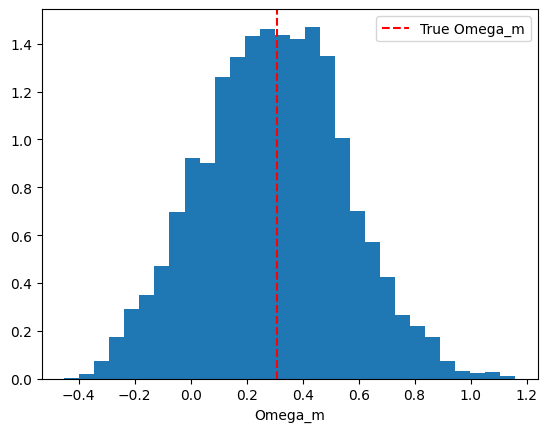

In [ ]:
plt.hist(samples_prod[:, :, 0].reshape(-1), bins=30, density=True)
plt.axvline(x0[0], color="r", linestyle="--", label="True Omega_m")
plt.xlabel("Omega_m")
plt.legend()
plt.show()

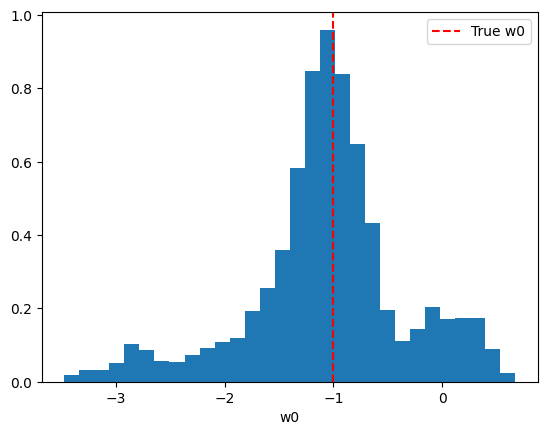

In [ ]:
plt.hist(samples_prod[:, :, 1].reshape(-1), bins=30, density=True)
plt.axvline(x0[1], color="r", linestyle="--", label="True w0")
plt.xlabel("w0")
plt.legend()
plt.show()

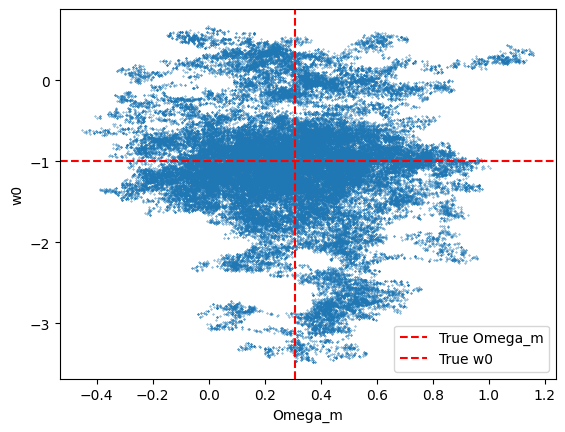

In [ ]:
plt.scatter(samples_prod[:, :, 0].reshape(-1), samples_prod[:, :, 1].reshape(-1), s=0.1)
plt.axvline(x0[0], color="r", linestyle="--", label="True Omega_m")
plt.axhline(x0[1], color="r", linestyle="--", label="True w0")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.legend()
plt.show()

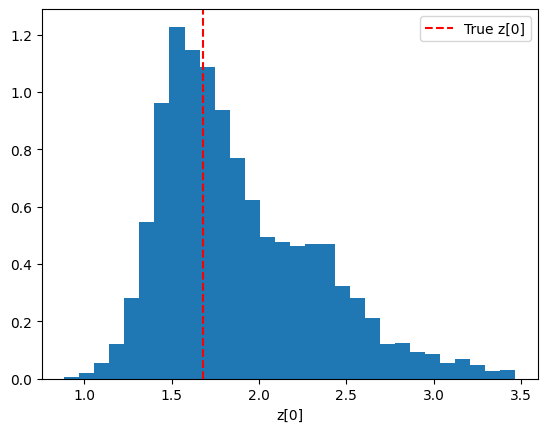

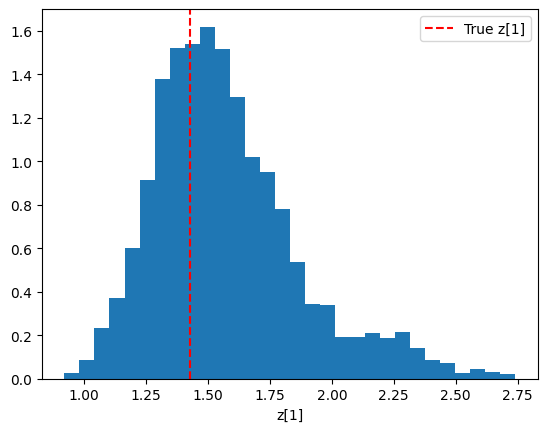

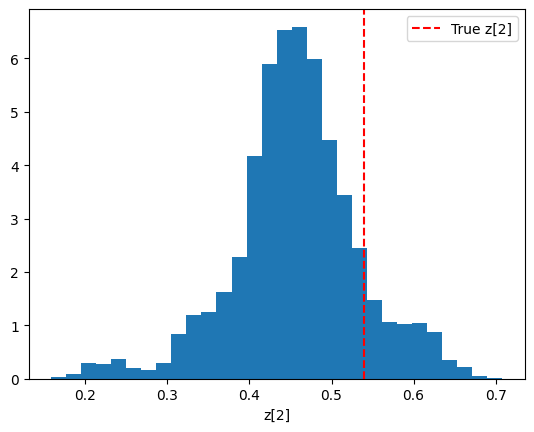

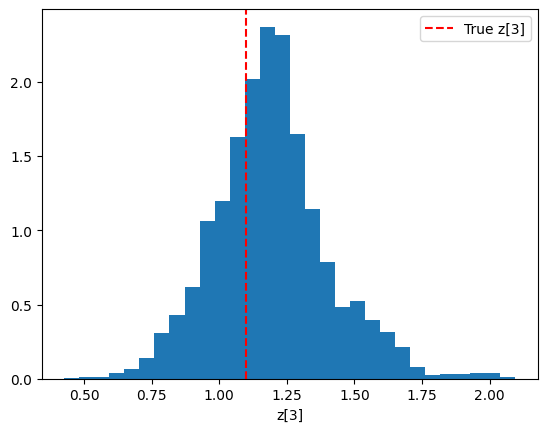

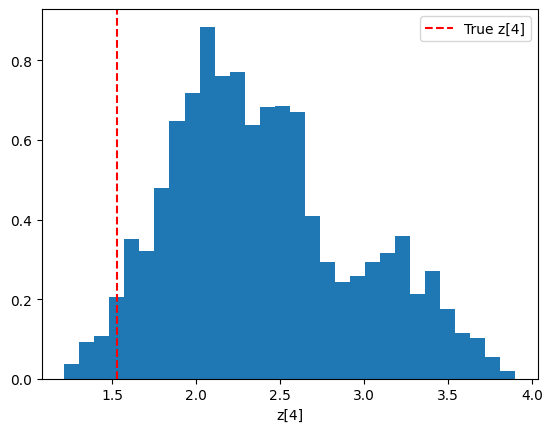

In [ ]:
for i in range(5):
    plt.hist(samples_prod[:, :, 2 + i].reshape(-1), bins=30, density=True)
    plt.axvline(x0[2 + i], color="r", linestyle="--", label=f"True z[{i}]")
    plt.xlabel(f"z[{i}]")
    plt.legend()
    plt.show()

In [ ]:
len(x0)

508